In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
ls

In [4]:
import os
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(0)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import  LSTM, Bidirectional
from tensorflow.keras.layers import  Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics

In [6]:
data = pd.read_csv("normalized_data.csv")

In [7]:
data.head()

,comment,label
0,we need mr chari 's review on master,NTL
1,worst government . #ysrcp chala cheta ga parip...,NEG
2,baya nuvu emina chepu kani bagoledu ani chepak...,NEG
3,gadini vadilesi manchi pani chesaru @rcbtweets 👍,POS
4,i came to watch thyview 's review crying after...,POS


In [8]:
data.shape

(19868, 2)

In [9]:
stop_words = set(stopwords.words('english'))

def preprocessor(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence).split()
    sentence = " ".join([i for i in sentence if not i in stop_words])
    return sentence



In [10]:
print(len(stop_words))

179


In [11]:
data.comment = data.comment.apply(preprocessor)

In [12]:
data.head()

,comment,label
0,need mr chari review master,NTL
1,worst government ysrcp chala cheta ga paripala...,NEG
2,baya nuvu emina chepu kani bagoledu ani chepak...,NEG
3,gadini vadilesi manchi pani chesaru rcbtweets,POS
4,came watch thyview review crying watching dil ...,POS


In [13]:
def convert(l):
  if l =="NTL":
    return 1.0
  elif l=="NEG":
    return 0.0
  else:
    return 2.0

In [14]:
data.label = data.label.apply(convert)

In [15]:
np.array(data.label.unique())

array([1., 0., 2.])

In [16]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(0)


In [17]:
vocab_size = 1000 
embedding_dim = 512
max_len = 300

batch_size=128
epochs=20

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>", lower=True)
binarizer = LabelBinarizer()

In [18]:
def bi_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics='accuracy')
    return model


In [19]:
# Plot history:
def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'], label='training data')
    plt.plot(history.history['val_loss'], label='validation data')
    plt.title('LOSS')
    plt.ylabel('Loss')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")

    # Plot history: Acc

    plt.figure()
    plt.plot(history.history['accuracy'], label='training data')
    plt.plot(history.history['val_accuracy'], label='validation data')
    plt.title('ACCURACY')
    plt.ylabel('Accuracy')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()


def evaluate_model(trained_model, y_test_true):
    y_test_preds = trained_model.predict(x_test)
    y_test_preds = np.argmax(y_test_preds, axis=1)
    y_test_preds = np.where(y_test_preds == 0, 0,y_test_preds)
    y_test_preds = np.where(y_test_preds == 1, 1, y_test_preds)
    y_test_preds = np.where(y_test_preds == 2, 2, y_test_preds)
    print(metrics.classification_report(y_test_true, y_test_preds))

    cm = metrics.confusion_matrix(y_test_true, y_test_preds, normalize='true')
    sns.heatmap(cm, annot=True, cbar=None, cmap='viridis')
    plt.show()

In [24]:

labels = data.label.tolist()

In [26]:
sentences = data.comment.tolist()

In [28]:
_ = tokenizer.fit_on_texts(sentences)

In [32]:
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
sequences

In [20]:

labels = data.label.tolist()
sentences = data.comment.tolist()
_ = tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_len)

x_train, x_test, y_train, y_test = train_test_split(
    padded_sequences, labels, stratify=labels, test_size=0.2, random_state=101)

y_test_true = y_test.copy()

y_train = binarizer.fit_transform(y_train)
y_test = binarizer.transform(y_test)

In [34]:
y_train = binarizer.fit_transform(y_train)

In [35]:
y_train

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [21]:
x_train.shape, x_test.shape

((15894, 300), (3974, 300))

In [36]:
binarizer.classes_

array([0, 1, 2])

Epoch 1/20
125/125 [==============================] - 78s 536ms/step - loss: 0.9343 - accuracy: 0.5263 - val_loss: 0.8720 - val_accuracy: 0.5571
Epoch 2/20
125/125 [==============================] - 71s 568ms/step - loss: 0.6280 - accuracy: 0.7225 - val_loss: 0.5670 - val_accuracy: 0.7496
Epoch 3/20
125/125 [==============================] - 72s 575ms/step - loss: 0.5086 - accuracy: 0.7808 - val_loss: 0.5396 - val_accuracy: 0.7662
Epoch 4/20
125/125 [==============================] - 73s 588ms/step - loss: 0.4799 - accuracy: 0.7941 - val_loss: 0.5309 - val_accuracy: 0.7733
Epoch 5/20
125/125 [==============================] - 72s 573ms/step - loss: 0.4637 - accuracy: 0.8013 - val_loss: 0.5249 - val_accuracy: 0.7781
Epoch 6/20
125/125 [==============================] - 71s 566ms/step - loss: 0.4545 - accuracy: 0.8075 - val_loss: 0.5289 - val_accuracy: 0.7730
Epoch 7/20
125/125 [==============================] - 71s 567ms/step - loss: 0.4481 - accuracy: 0.8119 - val_loss: 0.5404 - val_ac

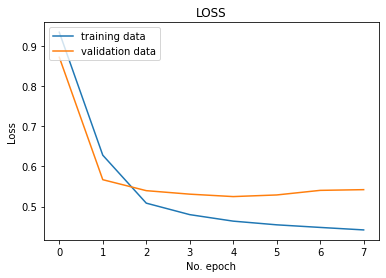

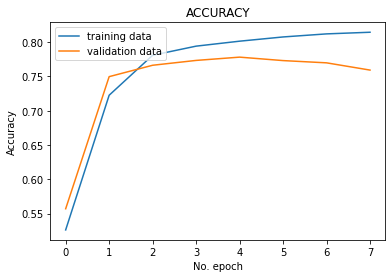

              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83      1544
         1.0       0.57      0.73      0.64       844
         2.0       0.79      0.75      0.77      1586

    accuracy                           0.76      3974
   macro avg       0.74      0.76      0.75      3974
weighted avg       0.78      0.76      0.76      3974



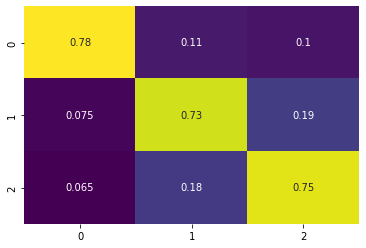

In [23]:
bi_lstm_model = bi_lstm()
checkpoint_path="bi_lstm_model.h5"
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=3, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
history = bi_lstm_model.fit(
    x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_test, y_test), callbacks=keras_callbacks)

plot_history(history)

evaluate_model(bi_lstm_model, y_test_true)

In [43]:
y_test_preds = bi_lstm_model.predict(x_test)

In [38]:
y_test_preds

array([[0.00216554, 0.00421141, 0.9936231 ],
       [0.00320666, 0.00592178, 0.9908716 ],
       [0.2650661 , 0.5020729 , 0.23286107],
       ...,
       [0.17264628, 0.57225496, 0.25509876],
       [0.07403021, 0.41545644, 0.51051337],
       [0.11238707, 0.64515007, 0.24246286]], dtype=float32)

In [44]:
y_test_preds = np.argmax(y_test_preds, axis=1)

In [45]:
print(metrics.classification_report(y_test_true, y_test_preds))

              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83      1544
         1.0       0.57      0.73      0.64       844
         2.0       0.79      0.75      0.77      1586

    accuracy                           0.76      3974
   macro avg       0.74      0.76      0.75      3974
weighted avg       0.78      0.76      0.76      3974

